# Testing different approaches for training an agent playing Tic-Tac-Toe

In [1]:
!git clone https://github.com/KunkelAlexander/tictactoe_rl.git

Cloning into 'tictactoe_rl'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 146 (delta 92), reused 119 (delta 67), pack-reused 0
Receiving objects: 100% (146/146), 1.78 MiB | 5.25 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [1]:
from src.tictactoe import TicTacToe
from src.game_manager import GameManager
from src.training_manager import TrainingManager
from src.gui import ascii_gui

training_manager = TrainingManager( game = TicTacToe(board_size  = 3, agent_count = 2),
                                    gui  = ascii_gui)

base_config = {
    "agent_types"         : ["RANDOM_AGENT", "RANDOM_AGENT"],
    "board_size"          : 3,
    "n_episode"           : 1000,
    "n_eval"              : 100,
    "eval_freq"           : 10,
    "train_freq"          : 10, 
    "discount"            : 0.99,
    "learning_rate_decay" : 1,
    "exploration"         : 1.0,
    "exploration_decay"   : 1-1e-3,
    "exploration_min"     : 0.1,
    "learning_rate"       : 1e-3,
    "randomise_order"     : False,
    "only_legal_actions"  : True,
    "debug"               : False,
    "batch_size"          : 64,
    "replay_buffer_size"  : 3000,
    "target_update_tau"   : 1e-3,
    "initial_q"           : 0.6,
}

## Games against agent playing random moves

episode


100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


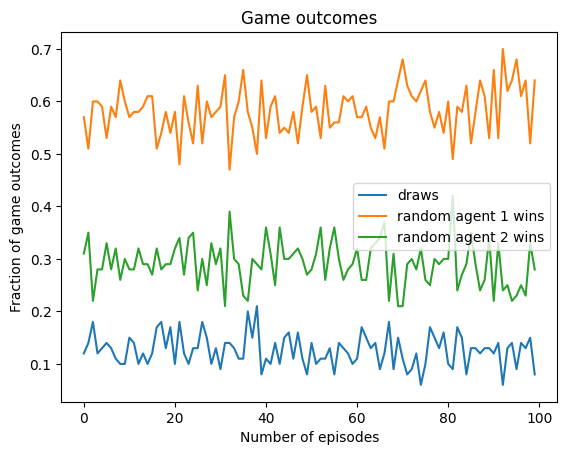

In [3]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "RANDOM_AGENT"]
config["n_eval"]        = 100
config["n_episode"]     = 100
config["eval_freq"]     = 1
out_random = training_manager.run_training(config)

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:12<00:00, 1561.58it/s] 


episode


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


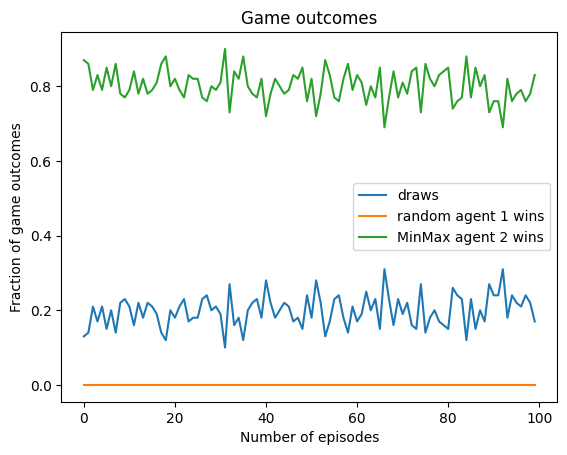

In [4]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "MINMAX_AGENT"]
config["n_eval"]        = 100
config["n_episode"]     = 100
config["eval_freq"]     = 1
out_minmax = training_manager.run_training(config)

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [03:38<00:00, 228.96it/s]


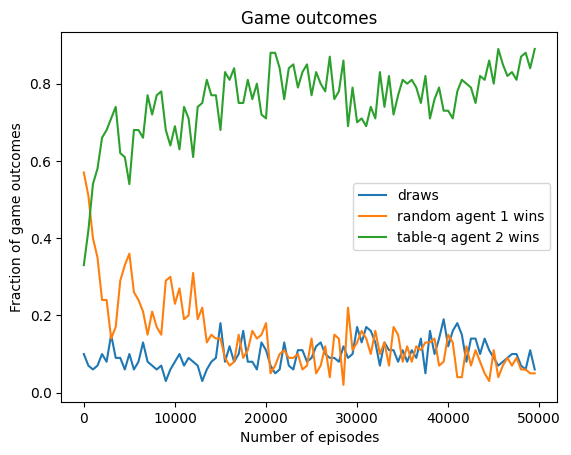

In [2]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]     = 50000
config["eval_freq"]     = 500
config["train_freq"]    = 500
config["learning_rate"] = 0.9
out_tabular = training_manager.run_training(config)

2023-09-28 13:38:34.803207: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 13:38:34.880355: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 13:38:34.881254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 13:38:36.666781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|██████████| 10000/10000 [05:17<00:00, 31.52it/s]


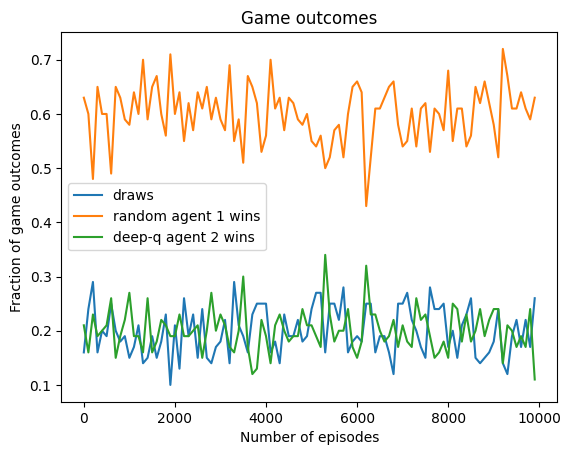

In [2]:
config = dict(base_config)
config["n_episode"]         = 10000
config["n_eval"]            = 100
config["eval_freq"]         = 100
config["train_freq"]        = 100 
config["exploration_decay"] = 3-1e-4
config["agent_types"]       = ["RANDOM_AGENT", "SIMPLE_DEEP_Q_AGENT"]
out_simple = training_manager.run_training(config)

episode


  0%|          | 1/1000 [00:01<20:53,  1.25s/it]

Evaluation on 100 episode: 0.0:1.0:0.0


 10%|█         | 100/1000 [00:21<02:44,  5.46it/s]

Update: 100, Loss: 0.0027619022876024246


 10%|█         | 102/1000 [00:23<06:39,  2.25it/s]

Evaluation on 100 episode: 0.02:0.59:0.39


 20%|██        | 200/1000 [00:46<02:30,  5.30it/s]

Update: 200, Loss: 0.003618949558585882


 20%|██        | 202/1000 [00:48<06:17,  2.11it/s]

Evaluation on 100 episode: 0.06:0.56:0.38


 30%|███       | 300/1000 [01:08<02:09,  5.42it/s]

Update: 300, Loss: 0.0032046139240264893


 30%|███       | 302/1000 [01:09<05:02,  2.30it/s]

Evaluation on 100 episode: 0.06:0.37:0.57


 40%|████      | 400/1000 [01:29<02:53,  3.47it/s]

Update: 400, Loss: 0.0036404114216566086


 40%|████      | 402/1000 [01:31<05:05,  1.96it/s]

Evaluation on 100 episode: 0.03:0.34:0.63


 50%|█████     | 500/1000 [01:51<01:36,  5.20it/s]

Update: 500, Loss: 0.004899481311440468


 50%|█████     | 501/1000 [01:52<04:39,  1.79it/s]

Evaluation on 100 episode: 0.0:0.37:0.63


 60%|██████    | 600/1000 [02:12<01:13,  5.41it/s]

Update: 600, Loss: 0.004114245064556599


 60%|██████    | 602/1000 [02:14<02:52,  2.31it/s]

Evaluation on 100 episode: 0.01:0.34:0.65


 70%|███████   | 700/1000 [02:34<01:13,  4.10it/s]

Update: 700, Loss: 0.004334890283644199


 70%|███████   | 702/1000 [02:36<02:43,  1.82it/s]

Evaluation on 100 episode: 0.02:0.33:0.65


 80%|████████  | 800/1000 [02:56<00:38,  5.25it/s]

Update: 800, Loss: 0.0032211027573794127


 80%|████████  | 801/1000 [02:57<01:42,  1.94it/s]

Evaluation on 100 episode: 0.01:0.34:0.65


 90%|█████████ | 900/1000 [03:18<00:26,  3.82it/s]

Update: 900, Loss: 0.004343903623521328


 90%|█████████ | 902/1000 [03:20<00:52,  1.87it/s]

Evaluation on 100 episode: 0.02:0.45:0.53


100%|██████████| 1000/1000 [03:39<00:00,  4.56it/s]


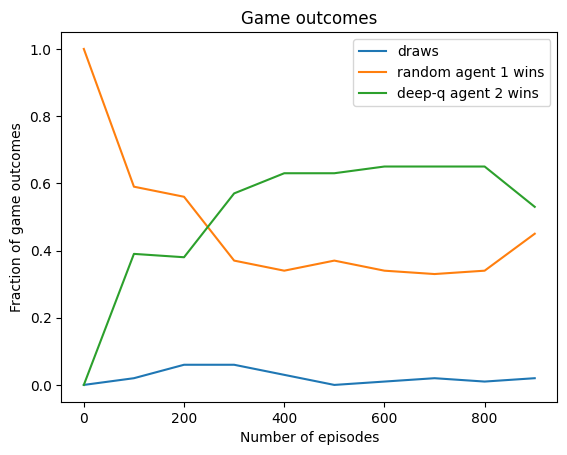

In [4]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "DUAL_DEEP_Q_AGENT"]
out_simple = training_manager.run_training(config)

episode


  1%|          | 9/1000 [00:02<02:52,  5.74it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 10%|█         | 100/1000 [00:23<03:26,  4.35it/s]

Update: 100, Loss: 0.004982318729162216


 10%|█         | 101/1000 [00:25<11:46,  1.27it/s]

Evaluation on 100 episode: 0.04:0.82:0.14


 20%|██        | 200/1000 [00:49<02:58,  4.47it/s]

Update: 200, Loss: 0.0053141070529818535


 20%|██        | 201/1000 [00:51<10:43,  1.24it/s]

Evaluation on 100 episode: 0.05:0.79:0.16


 30%|███       | 300/1000 [01:16<03:14,  3.60it/s]

Update: 300, Loss: 0.005223768763244152


 30%|███       | 301/1000 [01:18<10:19,  1.13it/s]

Evaluation on 100 episode: 0.04:0.53:0.43


 40%|████      | 400/1000 [01:42<02:21,  4.23it/s]

Update: 400, Loss: 0.005489150527864695


 40%|████      | 401/1000 [01:44<07:19,  1.36it/s]

Evaluation on 100 episode: 0.11:0.4:0.49


 50%|█████     | 500/1000 [02:07<02:03,  4.05it/s]

Update: 500, Loss: 0.005367914214730263


 50%|█████     | 501/1000 [02:09<06:22,  1.31it/s]

Evaluation on 100 episode: 0.08:0.37:0.55


 60%|██████    | 600/1000 [02:33<01:31,  4.39it/s]

Update: 600, Loss: 0.004132441245019436


 60%|██████    | 601/1000 [02:35<04:53,  1.36it/s]

Evaluation on 100 episode: 0.08:0.3:0.62


 70%|███████   | 700/1000 [02:59<01:04,  4.65it/s]

Update: 700, Loss: 0.006707402877509594


 70%|███████   | 701/1000 [03:01<03:29,  1.43it/s]

Evaluation on 100 episode: 0.05:0.2:0.75


 80%|████████  | 800/1000 [03:25<00:44,  4.51it/s]

Update: 800, Loss: 0.003704337403178215


 80%|████████  | 801/1000 [03:27<02:23,  1.39it/s]

Evaluation on 100 episode: 0.08:0.21:0.71


 90%|█████████ | 900/1000 [03:51<00:22,  4.45it/s]

Update: 900, Loss: 0.0039850156754255295


 90%|█████████ | 901/1000 [03:53<01:16,  1.29it/s]

Evaluation on 100 episode: 0.1:0.23:0.67


100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]


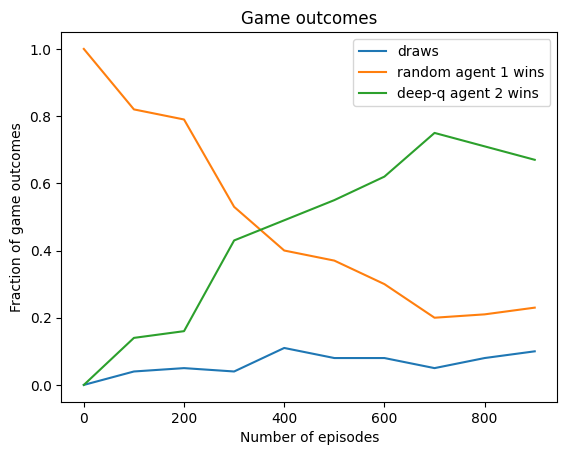

In [6]:
config = dict(base_config)
config["n_episode"]          = 1000
config["agent_types"]        = ["RANDOM_AGENT", "DUELLING_DEEP_Q_AGENT"]
out_duelling = training_manager.run_training(config)

episode


  0%|          | 1/500 [00:03<27:56,  3.36s/it]

Evaluation on 100 episode: 0.0:1.0:0.0


 20%|██        | 100/500 [00:46<03:02,  2.19it/s]

Update: 100, Loss: 0.004609433002769947


 20%|██        | 101/500 [00:50<10:44,  1.62s/it]

Evaluation on 100 episode: 0.0:0.83:0.17


 40%|████      | 200/500 [01:42<02:21,  2.12it/s]

Update: 200, Loss: 0.0056963954120874405


 40%|████      | 201/500 [01:45<06:55,  1.39s/it]

Evaluation on 100 episode: 0.0:0.78:0.22


 60%|██████    | 300/500 [02:35<01:33,  2.13it/s]

Update: 300, Loss: 0.006547357887029648


 60%|██████    | 301/500 [02:39<04:50,  1.46s/it]

Evaluation on 100 episode: 0.01:0.78:0.21


 80%|████████  | 400/500 [03:29<00:55,  1.80it/s]

Update: 400, Loss: 0.004768975079059601


 80%|████████  | 401/500 [03:33<02:23,  1.45s/it]

Evaluation on 100 episode: 0.0:0.52:0.48


100%|██████████| 500/500 [04:28<00:00,  1.86it/s]


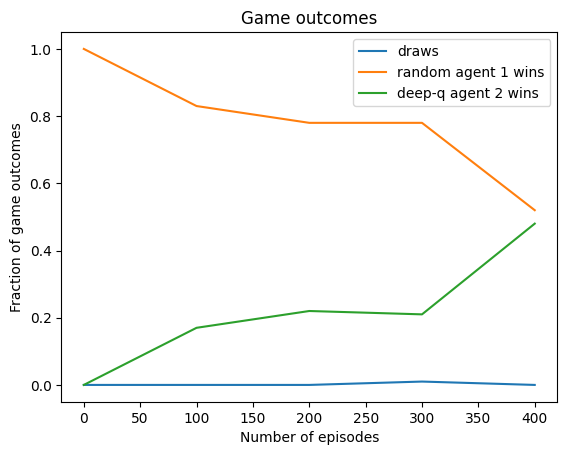

In [9]:
config = dict(base_config)
config["discount"]           = 0.99
config["exploration"]        = 1.0
config["exploration_decay"]  = 1 - 3e-4
config["n_episode"]          = 500
config["target_update_freq"] = 1
config["agent_types"]   = ["RANDOM_AGENT", "CONVOLUTIONAL_DUELLING_DEEP_Q_AGENT"]
out_convolutional = training_manager.run_training(config)

Creating prioritised experience replay buffer
episode


  0%|          | 4/1000 [00:01<05:21,  3.10it/s]

Evaluation on 100 episode: 0.0:0.98:0.02


 10%|█         | 101/1000 [00:24<08:26,  1.77it/s]

Evaluation on 100 episode: 0.02:0.67:0.31


 20%|██        | 201/1000 [00:49<07:47,  1.71it/s]

Evaluation on 100 episode: 0.05:0.49:0.46


 30%|███       | 301/1000 [01:14<06:37,  1.76it/s]

Evaluation on 100 episode: 0.12:0.38:0.5


 40%|████      | 401/1000 [01:39<05:22,  1.85it/s]

Evaluation on 100 episode: 0.03:0.42:0.55


 50%|█████     | 501/1000 [02:05<04:47,  1.74it/s]

Evaluation on 100 episode: 0.06:0.38:0.56


 60%|██████    | 601/1000 [02:30<03:41,  1.80it/s]

Evaluation on 100 episode: 0.07:0.26:0.67


 70%|███████   | 701/1000 [02:54<02:48,  1.77it/s]

Evaluation on 100 episode: 0.04:0.35:0.61


 80%|████████  | 801/1000 [03:19<02:03,  1.61it/s]

Evaluation on 100 episode: 0.07:0.21:0.72


 90%|█████████ | 901/1000 [03:45<01:11,  1.38it/s]

Evaluation on 100 episode: 0.12:0.18:0.7


100%|██████████| 1000/1000 [04:09<00:00,  4.00it/s]


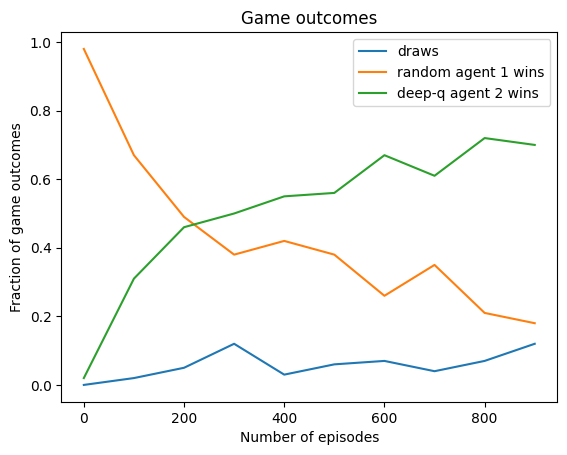

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "PRIORITISED_SIMPLE_DEEP_Q_AGENT"]
out_simple = training_manager.run_training(config)

## Playing first against the minmax agent

Eventually, all agents considered learn how to play 100% draws against the deterministic minmax agent.

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:07<00:00, 2522.11it/s] 


episode


  1%|          | 1/100 [00:01<02:26,  1.48s/it]

Evaluation on 1000 episode: 0.183:0.0:0.817


 11%|█         | 11/100 [00:03<00:22,  4.04it/s]

Evaluation on 1000 episode: 0.172:0.0:0.828


 21%|██        | 21/100 [00:04<00:15,  5.22it/s]

Evaluation on 1000 episode: 0.173:0.0:0.827


 31%|███       | 31/100 [00:06<00:12,  5.64it/s]

Evaluation on 1000 episode: 0.171:0.0:0.829


 41%|████      | 41/100 [00:07<00:10,  5.66it/s]

Evaluation on 1000 episode: 0.198:0.0:0.802


 51%|█████     | 51/100 [00:10<00:09,  5.00it/s]

Evaluation on 1000 episode: 0.197:0.0:0.803


 61%|██████    | 61/100 [00:11<00:07,  5.54it/s]

Evaluation on 1000 episode: 0.186:0.0:0.814


 71%|███████   | 71/100 [00:13<00:05,  5.74it/s]

Evaluation on 1000 episode: 0.212:0.0:0.788


 81%|████████  | 81/100 [00:14<00:03,  5.98it/s]

Evaluation on 1000 episode: 0.175:0.0:0.825


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]

Evaluation on 1000 episode: 0.198:0.0:0.802


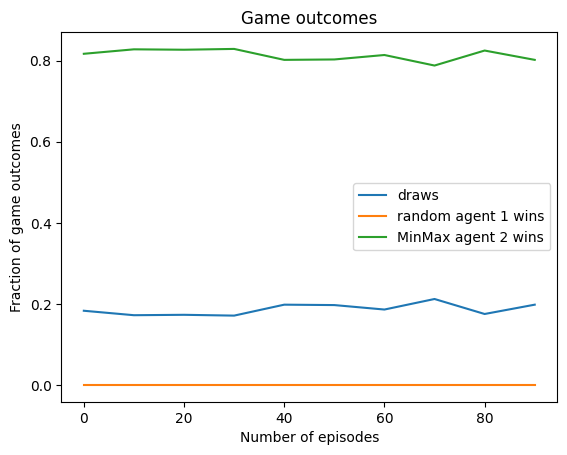

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "MINMAX_AGENT"]
config["n_eval"]        = 1000
config["n_episode"]     = 100
config["eval_freq"]     = 10
out_minmax = training_manager.run_training(config)

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:07<00:00, 2622.64it/s] 


episode


  0%|          | 1/50000 [00:00<2:35:27,  5.36it/s]

Evaluation on 100 episode: 0.12:0.0:0.88


 10%|█         | 5049/50000 [00:13<02:37, 285.26it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 20%|██        | 10086/50000 [00:27<02:13, 299.69it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 30%|███       | 15049/50000 [00:40<02:00, 290.00it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 40%|████      | 20051/50000 [00:53<01:43, 288.87it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 50%|█████     | 25070/50000 [01:06<01:26, 287.42it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 60%|██████    | 30057/50000 [01:19<01:07, 293.98it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 70%|███████   | 35045/50000 [01:33<00:52, 283.55it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 80%|████████  | 40067/50000 [01:46<00:33, 296.33it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 90%|█████████ | 45035/50000 [01:59<00:20, 248.21it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


100%|██████████| 50000/50000 [02:12<00:00, 377.48it/s]


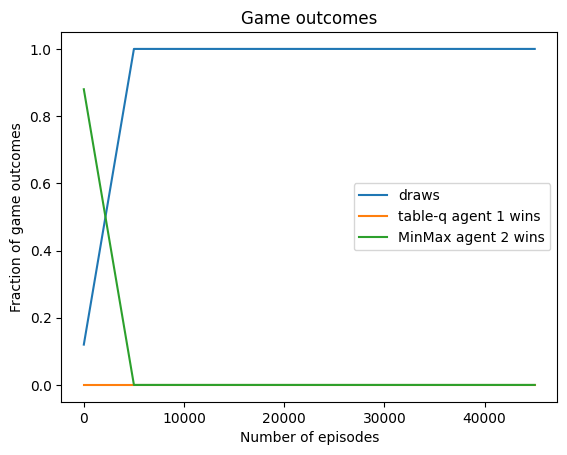

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["TABULAR_Q_AGENT", "MINMAX_AGENT"]
config["n_episode"]     = 50000
config["eval_freq"]     = 5000
config["learning_rate"] = 0.9
out_tabular = training_manager.run_training(config)

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:06<00:00, 3110.73it/s] 


episode


  1%|▏         | 13/1000 [00:01<01:31, 10.84it/s]

Evaluation on 100 episode: 0.0:0.0:1.0


 10%|█         | 100/1000 [00:20<02:38,  5.68it/s]

Update: 100, Loss: 0.0006352952914312482


 10%|█         | 102/1000 [00:22<07:56,  1.88it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 20%|██        | 200/1000 [00:41<03:09,  4.21it/s]

Update: 200, Loss: 0.00014211800589691848


 20%|██        | 202/1000 [00:43<08:34,  1.55it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 30%|███       | 300/1000 [01:02<02:09,  5.42it/s]

Update: 300, Loss: 4.763312608702108e-05


 30%|███       | 301/1000 [01:04<07:47,  1.49it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 40%|████      | 400/1000 [01:26<01:51,  5.36it/s]

Update: 400, Loss: 1.332048123003915e-05


 40%|████      | 402/1000 [01:28<05:21,  1.86it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 50%|█████     | 500/1000 [01:48<01:36,  5.17it/s]

Update: 500, Loss: 9.50844696490094e-06


 50%|█████     | 501/1000 [01:49<05:44,  1.45it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 60%|██████    | 600/1000 [02:10<01:19,  5.03it/s]

Update: 600, Loss: 3.5855977330356836e-05


 60%|██████    | 602/1000 [02:12<03:48,  1.74it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 70%|███████   | 700/1000 [02:33<00:56,  5.27it/s]

Update: 700, Loss: 8.907759183784947e-05


 70%|███████   | 702/1000 [02:35<02:48,  1.77it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 80%|████████  | 800/1000 [02:56<00:43,  4.61it/s]

Update: 800, Loss: 2.5498495233478025e-05


 80%|████████  | 801/1000 [02:58<02:27,  1.34it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 90%|█████████ | 900/1000 [03:19<00:20,  4.96it/s]

Update: 900, Loss: 0.00020443664107006043


 90%|█████████ | 902/1000 [03:21<00:53,  1.83it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s]


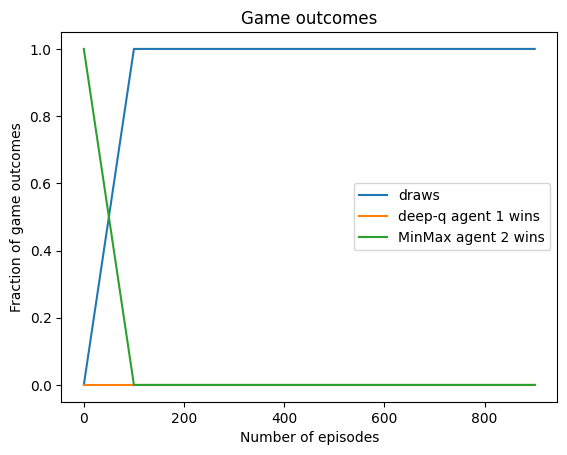

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["SIMPLE_DEEP_Q_AGENT", "MINMAX_AGENT"]
out_simple = training_manager.run_training(config)

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:06<00:00, 2868.50it/s] 


episode


  0%|          | 1/1000 [00:01<26:35,  1.60s/it]

Evaluation on 100 episode: 0.0:0.0:1.0


 10%|█         | 100/1000 [00:20<02:48,  5.35it/s]

Update: 100, Loss: 0.00029938778607174754


 10%|█         | 102/1000 [00:22<08:07,  1.84it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 20%|██        | 200/1000 [00:41<03:01,  4.42it/s]

Update: 200, Loss: 0.00010897011816268787


 20%|██        | 202/1000 [00:43<08:30,  1.56it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 30%|███       | 300/1000 [01:05<02:47,  4.18it/s]

Update: 300, Loss: 5.480145773617551e-05


 30%|███       | 302/1000 [01:07<07:28,  1.56it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 40%|████      | 400/1000 [01:27<01:58,  5.06it/s]

Update: 400, Loss: 2.2801454178988934e-05


 40%|████      | 401/1000 [01:29<07:17,  1.37it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 50%|█████     | 500/1000 [01:49<01:44,  4.80it/s]

Update: 500, Loss: 3.6931116483174264e-05


 50%|█████     | 501/1000 [01:51<05:52,  1.42it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 60%|██████    | 600/1000 [02:12<01:28,  4.50it/s]

Update: 600, Loss: 1.0017478416557424e-05


 60%|██████    | 602/1000 [02:14<03:41,  1.80it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 70%|███████   | 700/1000 [02:35<01:04,  4.69it/s]

Update: 700, Loss: 3.573411959223449e-05


 70%|███████   | 701/1000 [02:37<03:33,  1.40it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 80%|████████  | 800/1000 [02:58<00:40,  4.95it/s]

Update: 800, Loss: 8.808253369352315e-06


 80%|████████  | 802/1000 [03:00<01:47,  1.83it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 90%|█████████ | 900/1000 [03:20<00:22,  4.53it/s]

Update: 900, Loss: 1.93594278243836e-05


 90%|█████████ | 902/1000 [03:22<00:54,  1.79it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]


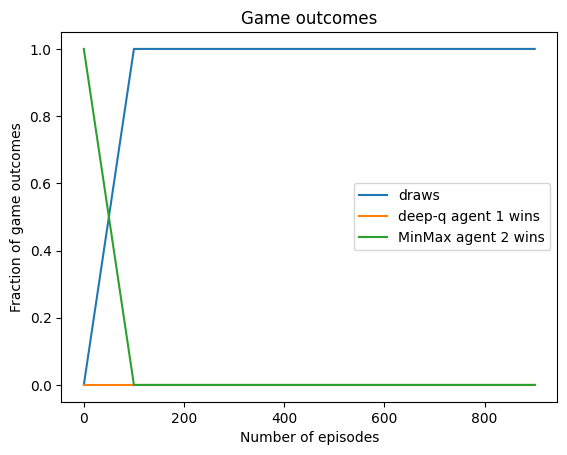

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["DUAL_DEEP_Q_AGENT", "MINMAX_AGENT"]
config["target_update_freq"] = 4
out_simple = training_manager.run_training(config)

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:06<00:00, 2973.02it/s] 


episode


  1%|▏         | 13/1000 [00:02<02:12,  7.47it/s]

Evaluation on 100 episode: 0.0:0.0:1.0


 10%|█         | 100/1000 [00:23<03:00,  5.00it/s]

Update: 100, Loss: 0.00045918108662590384


 10%|█         | 101/1000 [00:27<17:23,  1.16s/it]

Evaluation on 100 episode: 0.0:0.0:1.0


 20%|██        | 200/1000 [00:52<04:03,  3.28it/s]

Update: 200, Loss: 0.0008174094837158918


 20%|██        | 201/1000 [00:55<15:08,  1.14s/it]

Evaluation on 100 episode: 0.0:0.0:1.0


 30%|███       | 300/1000 [01:20<02:51,  4.07it/s]

Update: 300, Loss: 0.0010911119170486927


 30%|███       | 301/1000 [01:22<11:52,  1.02s/it]

Evaluation on 100 episode: 0.0:0.0:1.0


 40%|████      | 400/1000 [01:47<02:08,  4.65it/s]

Update: 400, Loss: 0.0006100814789533615


 40%|████      | 401/1000 [01:50<09:34,  1.04it/s]

Evaluation on 100 episode: 0.0:0.0:1.0


 50%|█████     | 500/1000 [02:15<01:59,  4.20it/s]

Update: 500, Loss: 0.001074720174074173


 50%|█████     | 501/1000 [02:18<09:23,  1.13s/it]

Evaluation on 100 episode: 0.0:0.0:1.0


 60%|██████    | 600/1000 [02:43<02:07,  3.14it/s]

Update: 600, Loss: 0.0015449365600943565


 60%|██████    | 601/1000 [02:46<07:37,  1.15s/it]

Evaluation on 100 episode: 1.0:0.0:0.0


 70%|███████   | 700/1000 [03:10<01:09,  4.30it/s]

Update: 700, Loss: 0.008865151554346085


 70%|███████   | 701/1000 [03:13<05:12,  1.05s/it]

Evaluation on 100 episode: 1.0:0.0:0.0


 80%|████████  | 800/1000 [03:40<00:52,  3.83it/s]

Update: 800, Loss: 0.0021676751784980297


 80%|████████  | 801/1000 [03:44<04:39,  1.40s/it]

Evaluation on 100 episode: 0.0:0.0:1.0


 90%|█████████ | 900/1000 [04:10<00:23,  4.17it/s]

Update: 900, Loss: 0.0018847191240638494


 90%|█████████ | 901/1000 [04:13<01:40,  1.01s/it]

Evaluation on 100 episode: 0.0:0.0:1.0


100%|██████████| 1000/1000 [04:38<00:00,  3.60it/s]


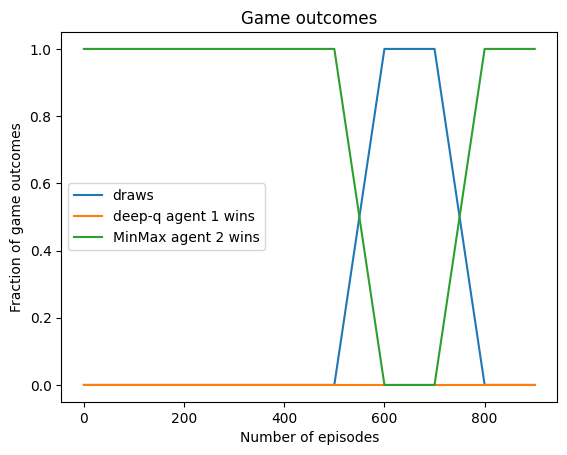

In [10]:
config = dict(base_config)
config["target_update_freq"] = 4
config["agent_types"]        = ["DUELLING_DEEP_Q_AGENT", "MINMAX_AGENT"]
out_duelling = training_manager.run_training(config)

Creating prioritised experience replay buffer
Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:07<00:00, 2780.59it/s] 


episode


  0%|          | 4/1000 [00:01<04:43,  3.52it/s]

Evaluation on 100 episode: 0.0:0.0:1.0


 10%|█         | 101/1000 [00:26<11:03,  1.36it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 20%|██        | 201/1000 [00:52<09:47,  1.36it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 30%|███       | 301/1000 [01:23<12:02,  1.03s/it]

Evaluation on 100 episode: 1.0:0.0:0.0


 40%|████      | 401/1000 [01:52<07:25,  1.35it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 50%|█████     | 501/1000 [02:20<06:20,  1.31it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 60%|██████    | 601/1000 [02:49<05:37,  1.18it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 70%|███████   | 701/1000 [03:16<03:43,  1.34it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 80%|████████  | 801/1000 [03:44<02:30,  1.32it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 90%|█████████ | 901/1000 [04:12<01:30,  1.09it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


100%|██████████| 1000/1000 [04:40<00:00,  3.57it/s]


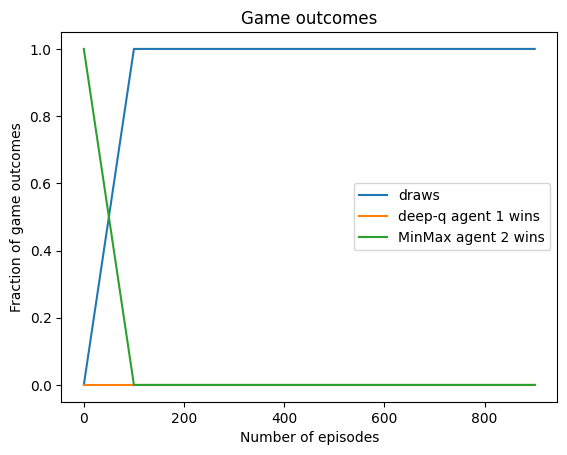

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["PRIORITISED_SIMPLE_DEEP_Q_AGENT", "MINMAX_AGENT"]
out_simple = training_manager.run_training(config)

## Playing second against the random minmax agent

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:07<00:00, 2700.77it/s] 


episode


  1%|          | 1/100 [00:01<02:15,  1.37s/it]

Evaluation on 1000 episode: 0.034:0.966:0.0


 11%|█         | 11/100 [00:02<00:20,  4.41it/s]

Evaluation on 1000 episode: 0.042:0.958:0.0


 21%|██        | 21/100 [00:04<00:13,  5.96it/s]

Evaluation on 1000 episode: 0.022:0.978:0.0


 31%|███       | 31/100 [00:05<00:10,  6.84it/s]

Evaluation on 1000 episode: 0.03:0.97:0.0


 41%|████      | 41/100 [00:06<00:08,  6.76it/s]

Evaluation on 1000 episode: 0.031:0.969:0.0


 51%|█████     | 51/100 [00:09<00:08,  5.58it/s]

Evaluation on 1000 episode: 0.038:0.962:0.0


 61%|██████    | 61/100 [00:10<00:06,  6.30it/s]

Evaluation on 1000 episode: 0.036:0.964:0.0


 71%|███████   | 71/100 [00:11<00:04,  6.79it/s]

Evaluation on 1000 episode: 0.031:0.969:0.0


 81%|████████  | 81/100 [00:12<00:02,  7.21it/s]

Evaluation on 1000 episode: 0.03:0.97:0.0


100%|██████████| 100/100 [00:14<00:00,  6.96it/s]

Evaluation on 1000 episode: 0.036:0.964:0.0


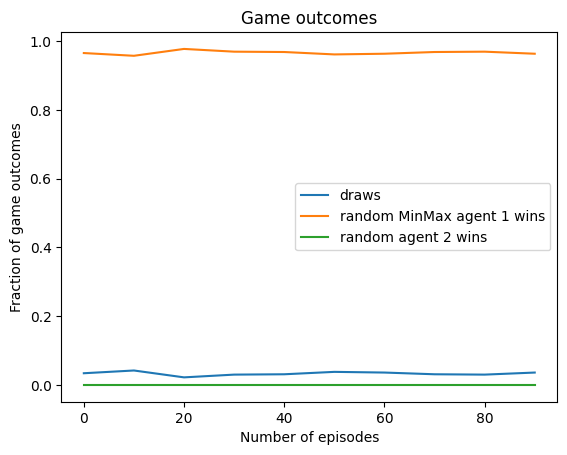

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "RANDOM_AGENT"]
config["n_eval"]        = 1000
config["n_episode"]     = 100
config["eval_freq"]     = 10
out_minmax = training_manager.run_training(config)

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:07<00:00, 2668.64it/s] 


episode


  0%|          | 1/50000 [00:00<2:03:58,  6.72it/s]

Evaluation on 100 episode: 0.02:0.98:0.0


 10%|█         | 5017/50000 [00:11<03:55, 191.05it/s]

Evaluation on 100 episode: 0.99:0.01:0.0


 20%|██        | 10070/50000 [00:25<02:12, 300.80it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 30%|███       | 15082/50000 [00:38<02:00, 290.50it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 40%|████      | 20060/50000 [00:51<01:43, 289.98it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 50%|█████     | 25088/50000 [01:04<01:23, 298.22it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 60%|██████    | 30061/50000 [01:18<01:06, 301.61it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 70%|███████   | 35061/50000 [01:31<00:51, 289.04it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 80%|████████  | 40068/50000 [01:45<00:34, 286.53it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 90%|█████████ | 45057/50000 [01:58<00:17, 284.22it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


100%|██████████| 50000/50000 [02:10<00:00, 381.84it/s]


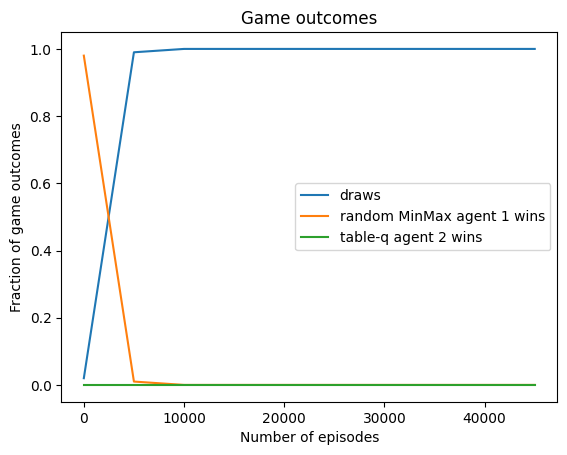

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]     = 50000
config["eval_freq"]     = 5000
config["learning_rate"] = 0.9
out_tabular = training_manager.run_training(config)

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:05<00:00, 3312.72it/s] 


episode


  0%|          | 1/2000 [00:01<36:46,  1.10s/it]

Evaluation on 100 episode: 0.0:1.0:0.0


  5%|▌         | 100/2000 [00:20<05:34,  5.68it/s]

Update: 100, Loss: 0.00013370475789997727


  5%|▌         | 102/2000 [00:22<12:37,  2.51it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 10%|█         | 200/2000 [00:41<05:31,  5.43it/s]

Update: 200, Loss: 0.00020987002062611282


 10%|█         | 201/2000 [00:42<14:52,  2.02it/s]

Evaluation on 100 episode: 0.02:0.98:0.0


 15%|█▌        | 300/2000 [01:03<07:21,  3.85it/s]

Update: 300, Loss: 0.00028119987109676003


 15%|█▌        | 302/2000 [01:05<13:17,  2.13it/s]

Evaluation on 100 episode: 0.03:0.97:0.0


 20%|██        | 400/2000 [01:23<04:50,  5.50it/s]

Update: 400, Loss: 0.0005027484148740768


 20%|██        | 402/2000 [01:25<11:07,  2.39it/s]

Evaluation on 100 episode: 0.1:0.9:0.0


 25%|██▌       | 500/2000 [01:45<05:06,  4.89it/s]

Update: 500, Loss: 0.0001883183722384274


 25%|██▌       | 502/2000 [01:46<10:43,  2.33it/s]

Evaluation on 100 episode: 0.16:0.84:0.0


 30%|███       | 600/2000 [02:06<04:58,  4.69it/s]

Update: 600, Loss: 0.0002714532020036131


 30%|███       | 602/2000 [02:07<09:49,  2.37it/s]

Evaluation on 100 episode: 0.17:0.83:0.0


 35%|███▌      | 700/2000 [02:26<03:55,  5.51it/s]

Update: 700, Loss: 0.0003345099976286292


 35%|███▌      | 701/2000 [02:27<12:33,  1.72it/s]

Evaluation on 100 episode: 0.14:0.86:0.0


 40%|████      | 800/2000 [02:47<03:33,  5.63it/s]

Update: 800, Loss: 0.000566488248296082


 40%|████      | 802/2000 [02:49<08:07,  2.46it/s]

Evaluation on 100 episode: 0.26:0.74:0.0


 45%|████▌     | 900/2000 [03:08<03:12,  5.72it/s]

Update: 900, Loss: 0.0002353715244680643


 45%|████▌     | 902/2000 [03:10<07:29,  2.44it/s]

Evaluation on 100 episode: 0.3:0.7:0.0


 50%|█████     | 1000/2000 [03:29<03:28,  4.81it/s]

Update: 1000, Loss: 0.0005731245619244874


 50%|█████     | 1002/2000 [03:31<07:11,  2.31it/s]

Evaluation on 100 episode: 0.34:0.66:0.0


 55%|█████▌    | 1100/2000 [03:49<02:39,  5.63it/s]

Update: 1100, Loss: 0.00048164918553084135


 55%|█████▌    | 1101/2000 [03:50<08:02,  1.86it/s]

Evaluation on 100 episode: 0.36:0.64:0.0


 60%|██████    | 1200/2000 [04:11<03:15,  4.10it/s]

Update: 1200, Loss: 0.0006671124137938023


 60%|██████    | 1202/2000 [04:12<06:16,  2.12it/s]

Evaluation on 100 episode: 0.35:0.65:0.0


 65%|██████▌   | 1300/2000 [04:33<02:03,  5.66it/s]

Update: 1300, Loss: 0.0005420606466941535


 65%|██████▌   | 1302/2000 [04:35<04:56,  2.36it/s]

Evaluation on 100 episode: 0.42:0.58:0.0


 70%|███████   | 1400/2000 [04:55<01:51,  5.38it/s]

Update: 1400, Loss: 0.0004931072471663356


 70%|███████   | 1402/2000 [04:56<04:25,  2.25it/s]

Evaluation on 100 episode: 0.57:0.43:0.0


 75%|███████▌  | 1500/2000 [05:15<01:31,  5.45it/s]

Update: 1500, Loss: 0.0005589763168245554


 75%|███████▌  | 1501/2000 [05:17<05:21,  1.55it/s]

Evaluation on 100 episode: 0.44:0.56:0.0


 80%|████████  | 1600/2000 [05:36<01:12,  5.50it/s]

Update: 1600, Loss: 0.00024426612071692944


 80%|████████  | 1602/2000 [05:38<03:01,  2.19it/s]

Evaluation on 100 episode: 0.59:0.41:0.0


 85%|████████▌ | 1700/2000 [05:58<01:07,  4.47it/s]

Update: 1700, Loss: 0.000317513186018914


 85%|████████▌ | 1702/2000 [05:59<02:15,  2.20it/s]

Evaluation on 100 episode: 0.57:0.43:0.0


 90%|█████████ | 1800/2000 [06:19<00:37,  5.28it/s]

Update: 1800, Loss: 0.0007476420141756535


 90%|█████████ | 1802/2000 [06:21<01:33,  2.12it/s]

Evaluation on 100 episode: 0.71:0.29:0.0


 95%|█████████▌| 1900/2000 [06:41<00:26,  3.72it/s]

Update: 1900, Loss: 0.00037513667484745383


 95%|█████████▌| 1902/2000 [06:43<00:54,  1.80it/s]

Evaluation on 100 episode: 0.74:0.26:0.0


100%|██████████| 2000/2000 [07:02<00:00,  4.73it/s]


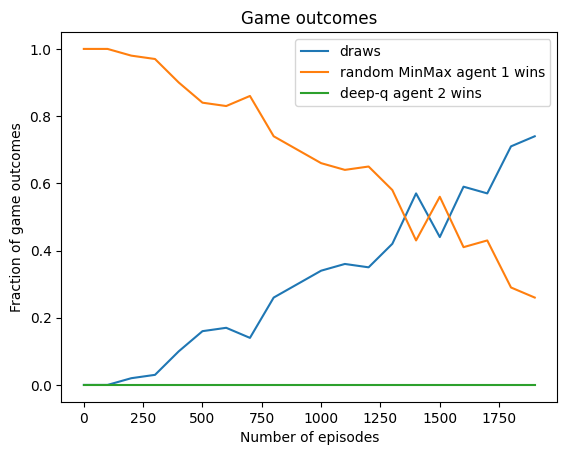

In [ ]:
config = dict(base_config)
config["n_episode"]     = 2000
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "SIMPLE_DEEP_Q_AGENT"]
out_simple = training_manager.run_training(config)

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:18<00:00, 1073.37it/s] 


episode


  1%|          | 17/2000 [00:10<14:37,  2.26it/s] 

Evaluation on 100 episode: 0.0:1.0:0.0


  5%|▌         | 100/2000 [00:51<14:44,  2.15it/s]

Update: 100, Loss: 0.00042146671330556273


  5%|▌         | 101/2000 [00:54<39:40,  1.25s/it]

Evaluation on 100 episode: 0.08:0.92:0.0


 10%|█         | 200/2000 [01:41<15:18,  1.96it/s]

Update: 200, Loss: 0.0013505748938769102


 10%|█         | 201/2000 [01:44<34:40,  1.16s/it]

Evaluation on 100 episode: 0.13:0.87:0.0


 15%|█▌        | 300/2000 [02:31<15:07,  1.87it/s]

Update: 300, Loss: 0.0009335764334537089


 15%|█▌        | 301/2000 [02:34<32:45,  1.16s/it]

Evaluation on 100 episode: 0.24:0.76:0.0


 20%|██        | 400/2000 [03:21<13:19,  2.00it/s]

Update: 400, Loss: 0.0011729397810995579


 20%|██        | 401/2000 [03:24<31:30,  1.18s/it]

Evaluation on 100 episode: 0.3:0.7:0.0


 25%|██▌       | 500/2000 [04:12<11:29,  2.18it/s]

Update: 500, Loss: 0.0009748131851665676


 25%|██▌       | 501/2000 [04:14<28:50,  1.15s/it]

Evaluation on 100 episode: 0.59:0.41:0.0


 30%|███       | 600/2000 [05:02<11:12,  2.08it/s]

Update: 600, Loss: 0.0005689586978405714


 30%|███       | 601/2000 [05:05<27:36,  1.18s/it]

Evaluation on 100 episode: 0.56:0.44:0.0


 35%|███▌      | 700/2000 [05:54<09:48,  2.21it/s]

Update: 700, Loss: 0.00034326183958910406


 35%|███▌      | 701/2000 [05:58<31:18,  1.45s/it]

Evaluation on 100 episode: 0.81:0.19:0.0


 40%|████      | 800/2000 [06:45<09:37,  2.08it/s]

Update: 800, Loss: 0.0005400670925155282


 40%|████      | 801/2000 [06:48<27:49,  1.39s/it]

Evaluation on 100 episode: 0.85:0.15:0.0


 45%|████▌     | 900/2000 [07:37<08:35,  2.13it/s]

Update: 900, Loss: 0.000543879228644073


 45%|████▌     | 901/2000 [07:40<22:49,  1.25s/it]

Evaluation on 100 episode: 0.92:0.08:0.0


 50%|█████     | 1000/2000 [08:31<07:41,  2.17it/s]

Update: 1000, Loss: 0.00023432324815075845


 50%|█████     | 1001/2000 [08:35<22:11,  1.33s/it]

Evaluation on 100 episode: 0.91:0.09:0.0


 55%|█████▌    | 1100/2000 [09:24<08:34,  1.75it/s]

Update: 1100, Loss: 0.0002406401908956468


 55%|█████▌    | 1101/2000 [09:27<22:06,  1.48s/it]

Evaluation on 100 episode: 0.88:0.12:0.0


 60%|██████    | 1200/2000 [10:14<06:40,  2.00it/s]

Update: 1200, Loss: 8.278509631054476e-05


 60%|██████    | 1201/2000 [10:17<17:21,  1.30s/it]

Evaluation on 100 episode: 0.92:0.08:0.0


 65%|██████▌   | 1300/2000 [11:07<04:57,  2.36it/s]

Update: 1300, Loss: 0.00016679824329912663


 65%|██████▌   | 1301/2000 [11:10<14:36,  1.25s/it]

Evaluation on 100 episode: 0.88:0.12:0.0


 70%|███████   | 1400/2000 [11:58<04:45,  2.10it/s]

Update: 1400, Loss: 0.0001642035786062479


 70%|███████   | 1401/2000 [12:01<13:15,  1.33s/it]

Evaluation on 100 episode: 0.89:0.11:0.0


 75%|███████▌  | 1500/2000 [12:49<04:06,  2.03it/s]

Update: 1500, Loss: 0.00024701759684830904


 75%|███████▌  | 1501/2000 [12:53<12:04,  1.45s/it]

Evaluation on 100 episode: 0.97:0.03:0.0


 80%|████████  | 1600/2000 [13:42<03:11,  2.09it/s]

Update: 1600, Loss: 0.00036550662480294704


 80%|████████  | 1601/2000 [13:45<08:17,  1.25s/it]

Evaluation on 100 episode: 0.91:0.09:0.0


 85%|████████▌ | 1700/2000 [14:32<02:02,  2.44it/s]

Update: 1700, Loss: 0.0001312061067437753


 85%|████████▌ | 1701/2000 [14:35<05:57,  1.20s/it]

Evaluation on 100 episode: 0.97:0.03:0.0


 90%|█████████ | 1800/2000 [15:23<01:25,  2.35it/s]

Update: 1800, Loss: 6.008864875184372e-05


 90%|█████████ | 1801/2000 [15:26<04:07,  1.25s/it]

Evaluation on 100 episode: 0.97:0.03:0.0


 95%|█████████▌| 1900/2000 [16:15<00:46,  2.14it/s]

Update: 1900, Loss: 2.6679022994358093e-05


 95%|█████████▌| 1901/2000 [16:19<02:30,  1.52s/it]

Evaluation on 100 episode: 0.94:0.06:0.0


100%|██████████| 2000/2000 [17:07<00:00,  1.95it/s]


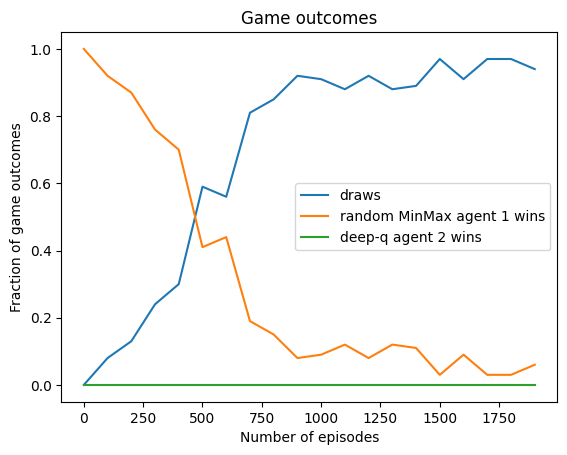

In [ ]:
config = dict(base_config)
config["n_episode"]     = 2000
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "CONVOLUTIONAL_DEEP_Q_AGENT"]
out_simple = training_manager.run_training(config)

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:06<00:00, 2991.31it/s] 


episode


  0%|          | 1/1000 [00:01<22:58,  1.38s/it]

Evaluation on 100 episode: 0.0:1.0:0.0


 10%|█         | 100/1000 [00:17<02:44,  5.48it/s]

Update: 100, Loss: 0.0004810303798876703


 10%|█         | 102/1000 [00:18<06:04,  2.46it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 20%|██        | 200/1000 [00:39<02:50,  4.69it/s]

Update: 200, Loss: 0.000517731299623847


 20%|██        | 202/1000 [00:40<05:49,  2.28it/s]

Evaluation on 100 episode: 0.02:0.98:0.0


 30%|███       | 300/1000 [01:00<03:01,  3.85it/s]

Update: 300, Loss: 0.00014881652896292508


 30%|███       | 302/1000 [01:02<05:37,  2.07it/s]

Evaluation on 100 episode: 0.02:0.98:0.0


 40%|████      | 400/1000 [01:21<01:56,  5.14it/s]

Update: 400, Loss: 0.0003435357939451933


 40%|████      | 402/1000 [01:22<04:10,  2.39it/s]

Evaluation on 100 episode: 0.32:0.68:0.0


 50%|█████     | 500/1000 [01:42<01:29,  5.59it/s]

Update: 500, Loss: 0.00037508405512198806


 50%|█████     | 502/1000 [01:44<03:33,  2.33it/s]

Evaluation on 100 episode: 0.41:0.59:0.0


 60%|██████    | 600/1000 [02:03<01:15,  5.33it/s]

Update: 600, Loss: 0.0004061276267748326


 60%|██████    | 602/1000 [02:05<02:47,  2.37it/s]

Evaluation on 100 episode: 0.33:0.67:0.0


 70%|███████   | 700/1000 [02:26<01:25,  3.49it/s]

Update: 700, Loss: 0.0005647961515933275


 70%|███████   | 701/1000 [02:28<03:06,  1.60it/s]

Evaluation on 100 episode: 0.41:0.59:0.0


 80%|████████  | 800/1000 [02:48<00:38,  5.14it/s]

Update: 800, Loss: 0.000841100700199604


 80%|████████  | 801/1000 [02:49<02:00,  1.66it/s]

Evaluation on 100 episode: 0.44:0.56:0.0


 90%|█████████ | 900/1000 [03:09<00:18,  5.38it/s]

Update: 900, Loss: 0.0007508443668484688


 90%|█████████ | 902/1000 [03:11<00:43,  2.27it/s]

Evaluation on 100 episode: 0.52:0.48:0.0


100%|██████████| 1000/1000 [03:32<00:00,  4.72it/s]


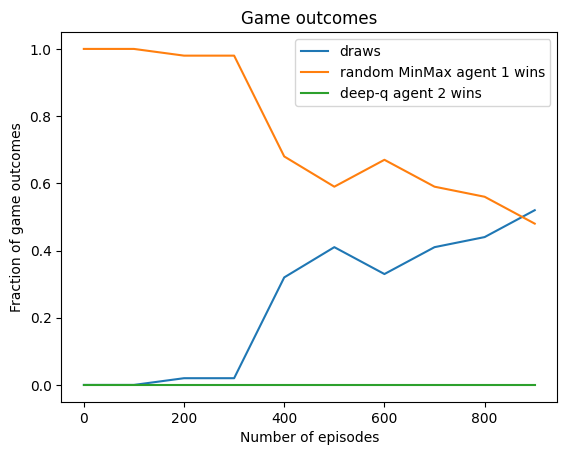

In [ ]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "DUAL_DEEP_Q_AGENT"]
config["target_update_freq"] = 50
out_simple = training_manager.run_training(config)

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:07<00:00, 2751.78it/s] 


episode


  1%|▏         | 14/1000 [00:02<01:45,  9.30it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 10%|█         | 100/1000 [00:20<03:09,  4.75it/s]

Update: 100, Loss: 0.00030639307806268334


 10%|█         | 101/1000 [00:22<11:26,  1.31it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 20%|██        | 200/1000 [00:46<03:05,  4.32it/s]

Update: 200, Loss: 0.0005420258967205882


 20%|██        | 201/1000 [00:48<11:00,  1.21it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 30%|███       | 300/1000 [01:11<02:31,  4.62it/s]

Update: 300, Loss: 0.000837426632642746


 30%|███       | 301/1000 [01:14<11:36,  1.00it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 40%|████      | 400/1000 [01:36<02:41,  3.72it/s]

Update: 400, Loss: 0.0004688008630182594


 40%|████      | 401/1000 [01:39<09:36,  1.04it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 50%|█████     | 500/1000 [02:02<02:35,  3.21it/s]

Update: 500, Loss: 0.0006115180440247059


 50%|█████     | 501/1000 [02:05<07:12,  1.15it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 60%|██████    | 600/1000 [02:29<01:32,  4.32it/s]

Update: 600, Loss: 0.0004961342783644795


 60%|██████    | 601/1000 [02:31<04:58,  1.34it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 70%|███████   | 700/1000 [02:55<01:04,  4.65it/s]

Update: 700, Loss: 0.0008570502977818251


 70%|███████   | 702/1000 [02:57<02:54,  1.71it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 80%|████████  | 800/1000 [03:20<00:45,  4.37it/s]

Update: 800, Loss: 0.0006618305342271924


 80%|████████  | 802/1000 [03:22<01:57,  1.69it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 90%|█████████ | 900/1000 [03:46<00:21,  4.59it/s]

Update: 900, Loss: 0.0007467668619938195


 90%|█████████ | 902/1000 [03:48<00:58,  1.68it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


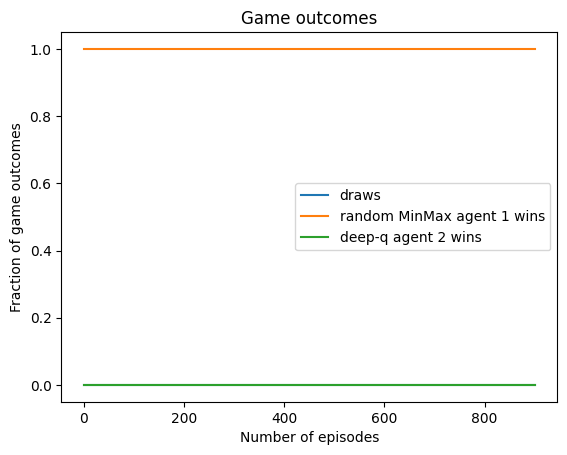

In [11]:
config = dict(base_config)
config["target_update_freq"] = 4
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "DUELLING_DEEP_Q_AGENT"]
out_duelling = training_manager.run_training(config)

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:06<00:00, 2818.91it/s] 


Creating prioritised experience replay buffer
episode


  0%|          | 5/2000 [00:01<06:36,  5.03it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


  5%|▌         | 101/2000 [00:21<16:48,  1.88it/s]

Evaluation on 100 episode: 0.02:0.98:0.0


 10%|█         | 201/2000 [00:46<16:23,  1.83it/s]

Evaluation on 100 episode: 0.1:0.9:0.0


 15%|█▌        | 302/2000 [01:10<12:17,  2.30it/s]

Evaluation on 100 episode: 0.09:0.91:0.0


 20%|██        | 401/2000 [01:35<14:37,  1.82it/s]

Evaluation on 100 episode: 0.16:0.84:0.0


 25%|██▌       | 501/2000 [02:01<16:22,  1.53it/s]

Evaluation on 100 episode: 0.64:0.36:0.0


 30%|███       | 601/2000 [02:26<14:16,  1.63it/s]

Evaluation on 100 episode: 0.68:0.32:0.0


 35%|███▌      | 701/2000 [02:53<13:30,  1.60it/s]

Evaluation on 100 episode: 0.78:0.22:0.0


 40%|████      | 801/2000 [03:19<12:55,  1.55it/s]

Evaluation on 100 episode: 0.86:0.14:0.0


 45%|████▌     | 901/2000 [03:45<14:54,  1.23it/s]

Evaluation on 100 episode: 0.88:0.12:0.0


 50%|█████     | 1001/2000 [04:10<11:29,  1.45it/s]

Evaluation on 100 episode: 0.8:0.2:0.0


 55%|█████▌    | 1101/2000 [04:37<09:31,  1.57it/s]

Evaluation on 100 episode: 0.91:0.09:0.0


 60%|██████    | 1201/2000 [05:05<08:53,  1.50it/s]

Evaluation on 100 episode: 0.93:0.07:0.0


 65%|██████▌   | 1301/2000 [05:30<07:22,  1.58it/s]

Evaluation on 100 episode: 0.93:0.07:0.0


 70%|███████   | 1401/2000 [05:57<06:58,  1.43it/s]

Evaluation on 100 episode: 0.94:0.06:0.0


 75%|███████▌  | 1501/2000 [06:23<06:33,  1.27it/s]

Evaluation on 100 episode: 0.9:0.1:0.0


 80%|████████  | 1601/2000 [06:49<04:16,  1.55it/s]

Evaluation on 100 episode: 0.96:0.04:0.0


 85%|████████▌ | 1701/2000 [07:17<03:23,  1.47it/s]

Evaluation on 100 episode: 0.94:0.06:0.0


 90%|█████████ | 1801/2000 [07:43<02:06,  1.57it/s]

Evaluation on 100 episode: 0.97:0.03:0.0


 95%|█████████▌| 1901/2000 [08:10<01:15,  1.32it/s]

Evaluation on 100 episode: 0.96:0.04:0.0


100%|██████████| 2000/2000 [08:34<00:00,  3.89it/s]


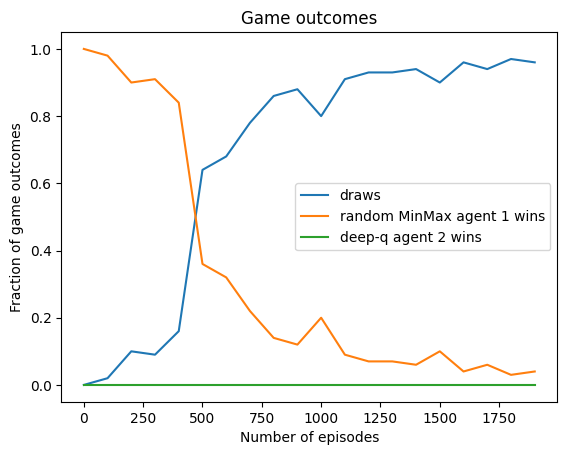

In [ ]:
config = dict(base_config)
config["n_episode"]     = 1000
config["exploration"]
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "PRIORITISED_SIMPLE_DEEP_Q_AGENT"]
out_simple = training_manager.run_training(config)

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:06<00:00, 2959.68it/s] 


episode


  0%|          | 3/2000 [00:02<21:29,  1.55it/s]  

Evaluation on 100 episode: 0.0:1.0:0.0


  5%|▌         | 101/2000 [00:48<33:02,  1.04s/it]

Evaluation on 100 episode: 0.0:1.0:0.0


 10%|█         | 201/2000 [01:44<32:31,  1.08s/it]

Evaluation on 100 episode: 0.0:1.0:0.0


 15%|█▌        | 301/2000 [02:39<30:09,  1.07s/it]

Evaluation on 100 episode: 0.04:0.96:0.0


 20%|██        | 401/2000 [03:36<31:03,  1.17s/it]

Evaluation on 100 episode: 0.21:0.79:0.0


 25%|██▌       | 501/2000 [04:34<32:46,  1.31s/it]

Evaluation on 100 episode: 0.36:0.64:0.0


 30%|███       | 601/2000 [05:30<29:54,  1.28s/it]

Evaluation on 100 episode: 0.49:0.51:0.0


 35%|███▌      | 701/2000 [06:29<28:59,  1.34s/it]

Evaluation on 100 episode: 0.73:0.27:0.0


 40%|████      | 801/2000 [07:29<26:32,  1.33s/it]

Evaluation on 100 episode: 0.82:0.18:0.0


 45%|████▌     | 901/2000 [08:27<24:52,  1.36s/it]

Evaluation on 100 episode: 0.89:0.11:0.0


 50%|█████     | 1001/2000 [09:29<22:00,  1.32s/it]

Evaluation on 100 episode: 0.92:0.08:0.0


 55%|█████▌    | 1101/2000 [10:30<20:19,  1.36s/it]

Evaluation on 100 episode: 0.95:0.05:0.0


 60%|██████    | 1201/2000 [11:29<18:20,  1.38s/it]

Evaluation on 100 episode: 0.92:0.08:0.0


 65%|██████▌   | 1301/2000 [12:30<15:41,  1.35s/it]

Evaluation on 100 episode: 0.95:0.05:0.0


 70%|███████   | 1401/2000 [13:29<13:36,  1.36s/it]

Evaluation on 100 episode: 0.94:0.06:0.0


 75%|███████▌  | 1501/2000 [14:28<11:52,  1.43s/it]

Evaluation on 100 episode: 0.99:0.01:0.0


 80%|████████  | 1601/2000 [15:29<10:27,  1.57s/it]

Evaluation on 100 episode: 0.93:0.07:0.0


 85%|████████▌ | 1701/2000 [16:29<07:10,  1.44s/it]

Evaluation on 100 episode: 0.97:0.03:0.0


 90%|█████████ | 1801/2000 [17:27<05:02,  1.52s/it]

Evaluation on 100 episode: 0.99:0.01:0.0


 95%|█████████▌| 1901/2000 [18:27<02:16,  1.38s/it]

Evaluation on 100 episode: 0.98:0.02:0.0


100%|██████████| 2000/2000 [19:23<00:00,  1.72it/s]


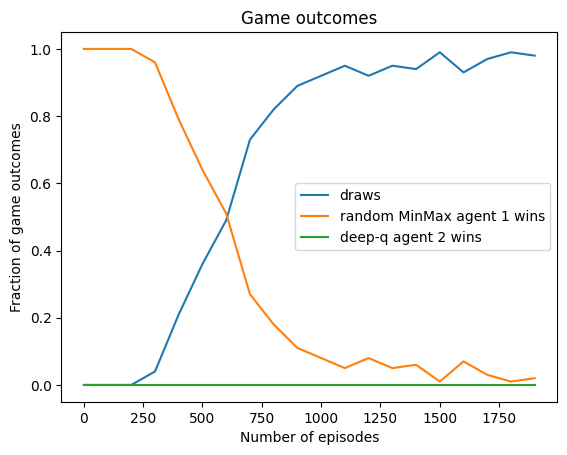

In [ ]:
config = dict(base_config)
config["n_episode"]     = 2000
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "PRIORITISED_CONVOLUTIONAL_DEEP_Q_AGENT"]
out_simple = training_manager.run_training(config)

## Self-training

episode


  0%|          | 28/10000 [00:00<02:28, 66.96it/s] 

Evaluation on 100 episode: 0.14:0.53:0.33


 10%|█         | 1048/10000 [00:05<00:53, 167.89it/s]

Evaluation on 100 episode: 0.0:0.46:0.54


 20%|██        | 2040/10000 [00:09<00:44, 178.02it/s]

Evaluation on 100 episode: 0.0:0.57:0.43


 30%|███       | 3043/10000 [00:13<00:42, 162.79it/s]

Evaluation on 100 episode: 0.23:0.42:0.35


 40%|████      | 4031/10000 [00:17<00:34, 173.21it/s]

Evaluation on 100 episode: 0.0:1.0:0.0


 50%|█████     | 5027/10000 [00:22<00:33, 146.67it/s]

Evaluation on 100 episode: 0.23:0.77:0.0


 60%|██████    | 6044/10000 [00:26<00:29, 133.31it/s]

Evaluation on 100 episode: 0.37:0.52:0.11


 70%|███████   | 7031/10000 [00:31<00:25, 115.42it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 80%|████████  | 8027/10000 [00:37<00:17, 115.61it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


 90%|█████████ | 9032/10000 [00:42<00:08, 116.52it/s]

Evaluation on 100 episode: 1.0:0.0:0.0


100%|██████████| 10000/10000 [00:47<00:00, 212.26it/s]


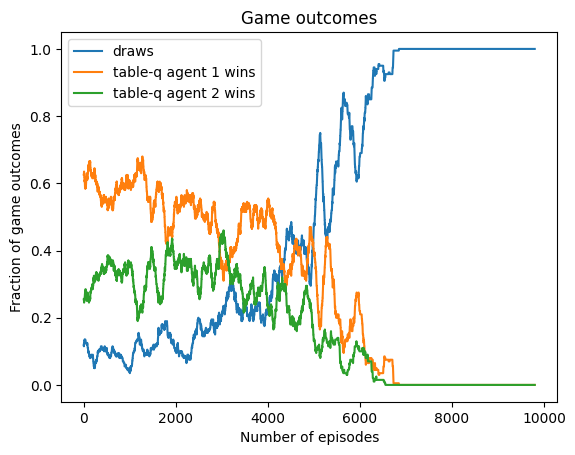

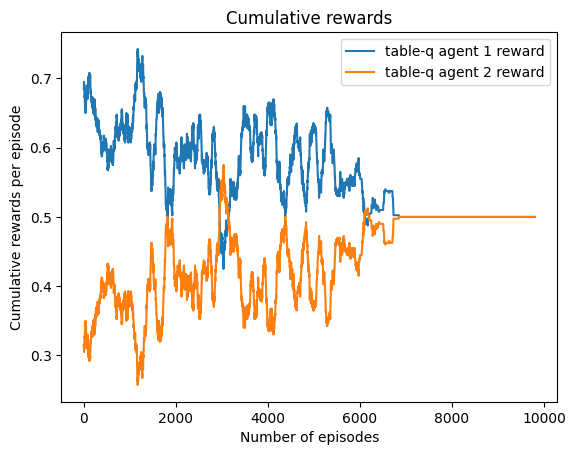

In [ ]:
config["agent_types"]       = ["TABULAR_Q_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]         = 10000
config["n_eval"]            = 100
config["eval_freq"]         = 1000
config["window_size"]       = 200
config["exploration"]       = 0.0
config["exploration_decay"] = 1-1e-4

agents2, draws, who_won, rewards = training_manager.run_training(config)